# Importing packages

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Installing UGent Panno font

Before running there are a few steps that need to be taken.

Download this: https://www.ugent.be/intranet/nl/op-het-werk/communicatie/huisstijl-presentaties/huisstijl/panno-text.zip
Unzip 'panno-text.zip'

Open and unzip '150831-ugentpannotext-v300-truetype.zip'

Upload the 'UGentPannoText-Normal' to this drive in the local directory!!!! (on the left bar, click the folder-icon, upload the 'UGentPannoText-Normal')

In [ ]:
font_files = fm.findSystemFonts('.')

for font_file in font_files:
    fm.fontManager.addfont(font_file)
print(font_files)
plt.rc('font', family='UGent Panno Text')

# Defining plot layout

In [ ]:
plt.style.use('bmh')
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

# Model definition

In [ ]:
def CNNK(kmer, tax, epochsize):
    print(f'Initiating training, validation and testing on {tax} level with {kmer}.')

    class mydataset(Dataset):
        def __init__(self, x, y):
            self.x = torch.tensor(x, dtype=torch.float32, device='cpu')
            self.y = torch.tensor(y, dtype=torch.long, device='cpu')
            self.length = self.x.shape[0]

        def __getitem__(self, idx):
            return self.x[idx], self.y[idx]

        def __len__(self):
            return self.length

    class ConvoNet(nn.Module):
        def __init__(self, input_shape, output_shape):
            super(ConvoNet, self).__init__()
            # First layer
            # Input shape = (100, 1, 125)
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=2, kernel_size=8, stride=1)
            self.relu = nn.ReLU()
            self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
            self.fc1 = nn.Linear(((input_shape - 1*(8 - 1) - 1)//1 + 1), output_shape)

        def forward(self, x):
            out = self.conv1(x)
            out = self.relu(out)
            out = self.pool(out)

            out = out.view(out.size(0), -1)  # flatten
            out = self.fc1(out)
            return out

    print('Model constructed...')

    # Load the existed Training & Validation & Testing Dataset
    base_path = '/content/drive/MyDrive/BachelorsProject/FinalModels/1NOAMBI/'

    # These files are all in my google drive
    TrainX = np.load(f'{base_path}Train_X_{kmer}1NA.npy')
    TrainY = np.load(f'{base_path}Train_Y_{tax}1NA.npy')
    TestX = np.load(f'{base_path}Test_X_{kmer}1NA.npy')
    TestY = np.load(f'{base_path}Test_Y_{tax}1NA.npy')
    ValX = np.load(f'{base_path}Validation_X_{kmer}1NA.npy')
    ValY = np.load(f'{base_path}Validation_Y_{tax}1NA.npy')
    print('Training, test and validation datasets are loaded...')

    batches = 100
    trainset = mydataset(TrainX, TrainY)
    valset = mydataset(ValX, ValY)
    testset = mydataset(TestX, TestY)
    trainloader = DataLoader(trainset, batch_size=batches, shuffle=True)
    valloader = DataLoader(valset, batch_size=batches, shuffle=False)
    testloader = DataLoader(testset, batch_size=batches, shuffle=False)
    print('Loading trainset, trainloader, testset, testloader ...')

    learning_rate = 0.001
    epochs = epochsize
    input_size = TrainX.shape[1]
    output_size = len(np.unique(TrainY))
    model = ConvoNet(input_shape=input_size, output_shape=output_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    print('Setting hyperparameters...')

    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []

    print('Training model...')
    for epoch in range(epochs):
        # Training loop
        model.train()
        training_loss = 0.0
        correct = 0
        total = 0
        for j, (x_train, y_train) in enumerate(trainloader):
            # calculate output
            x_train = x_train.unsqueeze(1)
            output = model(x_train)

            # calculate loss
            loss = loss_fn(output, y_train)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training loss and accuracy
            training_loss += loss.item() * x_train.size(0)
            output_tags = torch.argmax(output, dim=1)
            targets = y_train
            correct += (output_tags == targets).sum().item()
            total += y_train.size(0)

        # Print training statistics
        epoch_loss = training_loss / len(trainloader.dataset)
        epoch_acc = 100. * correct / total
        print(f'Epoch [{epoch + 1}] Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.2f}%')

        # Store the training loss and training accuracy
        training_losses.append(epoch_loss)
        training_accuracies.append(epoch_acc)

        # Validation loop
        model.eval()
        validation_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for j, (x_val, y_val) in enumerate(valloader):
                x_val = x_val.unsqueeze(1)
                output = model(x_val)
                loss = loss_fn(output, y_val)
                # Calculate validation loss and accuracy
                validation_loss += loss.item() * x_val.size(0)
                output_tags = torch.argmax(output, dim=1)
                targets = y_val
                correct += (output_tags == targets).sum().item()
                total += y_val.size(0)

        # Print validation statistics
        epoch_val_loss = validation_loss / len(valloader.dataset)
        epoch_val_acc = 100. * correct / total
        print(f'Epoch [{epoch + 1}] Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%')

        # Store the validation loss and validation accuracy
        validation_losses.append(epoch_val_loss)
        validation_accuracies.append(epoch_val_acc)

    # Testing
    with torch.no_grad():
        y_pred = []
        y_true = []
        # simple accuracy as above
        for x_test, y_test in testloader:
            x_test = x_test.unsqueeze(1)
            test_output = model(x_test)
            y_pred += torch.argmax(test_output, dim=1).tolist()
            y_true += y_test.tolist()
        report_dict = metrics.classification_report(y_true, y_pred, digits=3)
        print(report_dict)

    plt.plot(training_losses, label='Training', color='#1E64C8', linewidth=1)
    plt.plot(validation_losses, label='Validation', color='black', linewidth=1)
    plt.title(f'Training and Validation Loss of the CNN on {tax} level with {kmer}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (in %)')
    plt.legend()
    plt.savefig(f'CNNK{tax}{kmer}Loss1NA.svg')
    files.download(f'CNNK{tax}{kmer}Loss1NA.svg') 
    plt.show()

    plt.plot(training_accuracies, label='Training', color='#1E64C8', linewidth=1)
    plt.plot(validation_accuracies, label='Validation', color='black', linewidth=1)
    plt.title(f'Training and Validation Accuracy of the CNN on {tax} level with {kmer}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (in %)')
    plt.legend()
    plt.savefig(f'CNNK{tax}{kmer}Accuracy1NA.svg')
    files.download(f'CNNK{tax}{kmer}Accuracy1NA.svg') 
    plt.show()
    print(f'Training, validation and testing on {tax} level with {kmer} is completed.')

# 3mer - 200 epoch

In [ ]:
CNNK('3mer', 'PHYLUM', 200)

In [ ]:
CNNK('3mer', 'CLASS', 200)

Initiating training, validation and testing on ORDER level with 3mer.
Model constructed...
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 3.1723, Training Accuracy: 24.30%
Epoch [1] Validation Loss: 3.0724, Validation Accuracy: 24.55%
Epoch [2] Training Loss: 3.0679, Training Accuracy: 24.67%
Epoch [2] Validation Loss: 3.0728, Validation Accuracy: 24.55%
Epoch [3] Training Loss: 3.0657, Training Accuracy: 24.67%
Epoch [3] Validation Loss: 3.0684, Validation Accuracy: 24.55%
Epoch [4] Training Loss: 3.0594, Training Accuracy: 24.67%
Epoch [4] Validation Loss: 3.0578, Validation Accuracy: 24.55%
Epoch [5] Training Loss: 3.0438, Training Accuracy: 24.67%
Epoch [5] Validation Loss: 3.0337, Validation Accuracy: 24.55%
Epoch [6] Training Loss: 3.0094, Training Accuracy: 24.67%
Epoch [6] Validation Loss: 2.9866, Validation Accuracy: 24.55%
Epoch [7] Training Loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

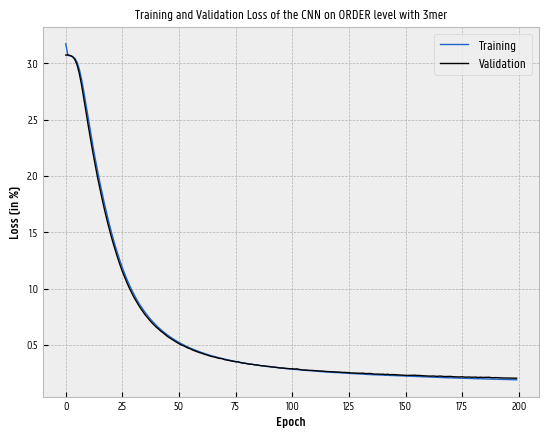

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

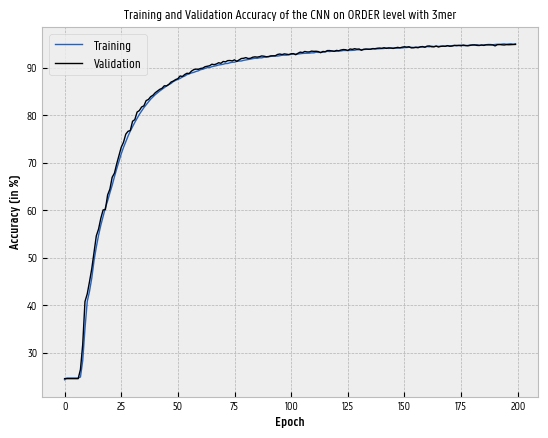

Training, validation and testing on ORDER level with 3mer is completed.


In [ ]:
CNNK('3mer', 'ORDER', 200)

Initiating training, validation and testing on FAMILY level with 3mer.
Model constructed...
Training, test and validation datasets are loaded...
Loading trainset, trainloader, testset, testloader ...
Setting hyperparameters...
Training model...
Epoch [1] Training Loss: 4.2021, Training Accuracy: 9.08%
Epoch [1] Validation Loss: 4.1071, Validation Accuracy: 10.78%
Epoch [2] Training Loss: 4.1202, Training Accuracy: 10.34%
Epoch [2] Validation Loss: 4.1087, Validation Accuracy: 10.78%
Epoch [3] Training Loss: 4.1194, Training Accuracy: 10.34%
Epoch [3] Validation Loss: 4.1072, Validation Accuracy: 10.78%
Epoch [4] Training Loss: 4.1194, Training Accuracy: 10.34%
Epoch [4] Validation Loss: 4.1043, Validation Accuracy: 10.78%
Epoch [5] Training Loss: 4.1167, Training Accuracy: 10.34%
Epoch [5] Validation Loss: 4.1015, Validation Accuracy: 10.78%
Epoch [6] Training Loss: 4.1130, Training Accuracy: 10.34%
Epoch [6] Validation Loss: 4.0956, Validation Accuracy: 10.78%
Epoch [7] Training Loss:

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

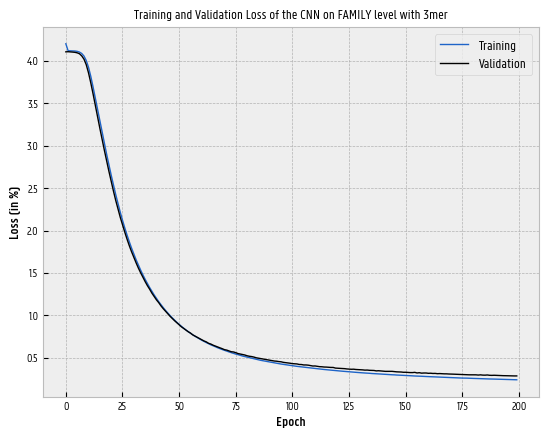

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

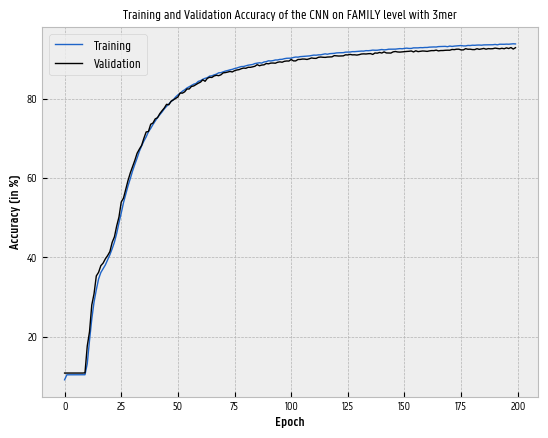

Training, validation and testing on FAMILY level with 3mer is completed.


In [ ]:
CNNK('3mer', 'FAMILY', 200)

In [ ]:
CNNK('3mer', 'GENUS', 200)

# 4mer - 100 epoch

In [ ]:
CNNK('4mer', 'PHYLUM', 100)

In [ ]:
CNNK('4mer', 'CLASS', 100)

In [ ]:
CNNK('4mer', 'ORDER', 100)

In [ ]:
CNNK('4mer', 'FAMILY', 100)

In [ ]:
CNNK('4mer', 'GENUS', 100)

# 5mer - 50 epoch

In [ ]:
CNNK('5mer', 'PHYLUM', 50)

In [ ]:
CNNK('5mer', 'CLASS', 50)

In [ ]:
CNNK('5mer', 'ORDER', 50)

In [ ]:
CNNK('5mer', 'FAMILY', 50)

In [ ]:
CNNK('5mer', 'GENUS', 50)